# Part 6 - Predicting Review Classifications

## Tasks
For this part of the project, you will using machine learning and deep NLP to classify the reviews.
### Repo Prep


- Create a `"Models/"` folder in your project repository, with the following sub-folders: 
    - `"Models/ml/"`. You will save your sklearn model pipelines here for later use in deployment.
    - `"Models/nn/"`. You will save your tensorflow models here for later use in deployment.
- Add new subfolders to your "Data-NLP/"" folder.
    - Specifically, create:
        - `"Data-NLP/ml/"` folder. We will save your training and test data (X_train,y_train) for later use in deployment.
        - `"Data-NLP/nn/"` folder.  We will save your training and test Tensorflow datasets for later use in deployment.
     

    
- Create a new notebook for Part 6 - Review Classification for this part of the project. 

### Load the Data

- Load the joblib containing the dataframe from Part 5 of the project.
- Use the original review column as X and the classiifcation target (High/Low Rating Reviews) as y.

___

## Machine Learning
For this project, you will use modeling pipelines with the text vectorizer and model in the same pipeline. This will make it very easy to use save and load the models to use in a deployed application.


### Create a Text Vectorizer
- Select an sklearn vectorizer to for your task.
    - Remember to consider your preprocessing choices like using stopwords, using ngrams, etc.

### Build a Machine Learning Model

- Build an sklearn modeling pipeline with a text vectorizer and a classification model.
    - Suggested Models: MultinomialNB, LogisticRegression, RandomForestClassifier 

- Fit and evaluate the model using the machine learning classification models from sklearn.
    - In a Markdown cell, document your observations from your results. (e.g. how good is the model overall? Is it particularly good/bad at predicting one class?)


### GridSearch Text Vectorization 
Attempt to improve on yourm model by tuning the text preprocessing steps. 

- Construct a grid of parameters for the text vectorization step. Consider trying:
    - CountVectorizer/TfidfVectorizer
    - stopwords
    - ngram_range
    - min_df/max_df

- Fit and evaluate the gridsearch results:
    - What were the best parameters?
    - How does the best estimator perform when evaluated on the training and test data?
 

### Save the Best Model and Train/Test Data  as Joblibs

- Save your overall best model pipeline as the only variable in a .joblib file in your new Models/ folder. (e.g. "Models/ml/best-clf-logreg.joblib")

- Save a list containing `[X_train, y_train]` as `"Data-NLP/ml/train-data.joblib"`
- Save a list containing `[X_test,y_test]`  as `"Data-NLP/ml/test-data.joblib"`


____

## Deep NLP (RNNs)
For this part of the project, you will use a Keras TextVectorization layer as part of your RNN model. This serves the same purpose as using the sklearn pipeline: it bundles text preparation into the model itself, making it deployment-ready.

 
###  Create train/test/val datasets
- Convert the target categories to integers (e.g. Using sklearn's LabelEncoder) 
- Create a tensorflow dataset using the X and  (integer version) of y.
- Split the dataset into a training, test, and validation datasets.

### Create a Keras Text Vectorization layer
- Create a keras text vectorization layer to use in an RNN (sequence) model.
- Fit/Adapt the text vectorization layer on the training texts.
- Save the vocabulary size from layer to use in your models' Embedding layer.


### Build an RNN with the TextVectorization Layer
- Build and fit at least 1 sequence model (LSTM, GRU, Bidirectional, etc)
- Evalaute the model on the training and trest data.
    - In a Markdown cell, document your observations from your results. (e.g. How did the RNN compare to your ML model? Was it superior to your ML model in some way (e.g. accuracy, recall, etc.)


### Save your best RNN model and Tensforflow Datasets

- Save your best neural network in a subfolder inside your `"Models/nn/` folder. (e.g. "Models/nn/lstm/")
    - Reminder: use safe_format='tf' to save the model in a folder of repo-friendly files. 

- Save your training and test Tensorflow dataset objects in "Data/nn/":
    - Save your training dataset object as `"Data-NLP/nn/train/"`
    - Save your test dataset object  as `"Data-NLP/nn/test/"`"



### 


In [1]:
import json
with open("config/filepaths.json") as f:
    FPATHS = json.load(f)
FPATHS['data']

{'raw': {'movie-reviews': 'Data-NLP/tmdb-movie-reviews.csv.gz',
  'movie-info': 'Data-NLP/tmdb-movie-info.csv.gz',
  'movie-reviews-with-info-json': 'Data-NLP/combined-tmdb-movie-reviews-with-info.json',
  'eda': 'Data-NLP/eda-movie-reviews.csv.gz',
  'processed-joblib': 'Data-NLP/processed-nlp-reviews.joblib',
  'processed-json': 'Data-NLP/processed-nlp-reviews.json'},
 'ml': {'reviews-with-target-json': 'Data-NLP/processed-nlp-reviews-for-ml.json',
  'train': 'Data-NLP/training-data.joblib',
  'test': 'Data-NLP/testing-data.joblib'},
 'nn': {'train': 'data/training-data-tf/', 'test': 'data/testing-data-tf/'}}

# Code

In [2]:
## Run code to get reproducible results BEFORE anything else
import tensorflow as tf
import numpy as np

# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# Source: https://discuss.tensorflow.org/t/upgrading-os-to-sonoma-on-my-mac-causing-tensorflow-errors/19846/5
tf.config.set_visible_devices([], 'GPU')

In [3]:
%load_ext autoreload
%autoreload 2

import project_functions as fn
# import custom_functions as fn

In [4]:
!pip install -U dojo_ds -q
import dojo_ds as ds
ds.__version__

'1.0.9'

In [5]:
import os
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

# fav_style = ('ggplot','fivethirtyeight')
# plt.style.use(fav_style)
fav_context  ={'context':'notebook', 'font_scale':1.1}

sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'





## Making New Folders 
# dirs = ["Data/",'Data/ml/',"Models/","Models/keras/"]
# for folder in dirs:
#     os.makedirs(folder, exist_ok=True)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from sklearn import set_config
set_config(transform_output='pandas')


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth',250)

## Load Data (Options)

### Opt A) ~~CSV~~ JSON (From Part 6B)

In [7]:
fpath_data = FPATHS['data']['ml']['reviews-with-target-json']
fpath_data

'Data-NLP/processed-nlp-reviews-for-ml.json'

In [8]:
# df =  pd.read_csv('Data-NLP/combined-tmdb-movie-reviews.csv.gz')
df = pd.read_json(fpath_data)
df

,imdb_id,movie_id,budget,revenue,original_title,original_language,overview,tagline,certification,review_id,rating,review_text,created_at,review_text_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,profit,target-profit,ROI,target-ROI,target-rating
0,tt2096672,100042,40000000,169837010,Dumb and Dumber To,en,"20 years since their first adventure, Lloyd and Harry go on a road trip to find Harry's newly discovered daughter, who was given up for adoption.",The average person uses 10% of their brain capacity. Imagine what he could do with 1%.,PG-13,64a3999fe9da6900c763aa8d,7.0,Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.,2023-07-04 04:01:35.517,Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.,"[better, then, the, original, i, think, was, pretty, funny, i, thought, the, comedy, was, better, then, the, original, too]","[better, original, think, pretty, funny, thought, comedy, better, original]","[well, original, think, pretty, funny, think, comedy, well, original]",better then the original i think was pretty funny i thought the comedy was better then the original too,better original think pretty funny thought comedy better original,well original think pretty funny think comedy well original,129837010,True,3.245925,2_Blockbuster,Mid
1,tt0429573,10008,14000000,29612137,An American Haunting,en,Based on the true events of the only case in US History where a spirit caused the death of a man.,Possession Knows No Bounds,None,643d44864d67910469d853a2,5.0,Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.,2023-04-17 13:07:18.832,Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.,"[kind, of, boring, it, 's, a, good, plot, and, storyline, nothing, really, to, keep, you, interested]","[kind, boring, good, plot, storyline, interested]","[kind, boring, good, plot, storyline, interested]",kind of boring it 's a good plot and storyline nothing really to keep you interested,kind boring good plot storyline interested,kind boring good plot storyline interested,15612137,True,1.115153,1_Successful,Mid
2,tt0328880,10009,128000000,250397798,Brother Bear,en,"When an impulsive boy named Kenai is magically transformed into a bear, he must literally walk in another's footsteps until he learns some valuable life lessons. His courageous and often zany journey introduces him to a forest full of wildlife, i...",Nature Calls,G,5f22bd2b43999b00355b26a6,7.0,"Heartwarming, if not as impactful as it intends to be.\r\n\r\n'Brother Bear' leaves heartfelt feelings and features a cute story. It does get a bit too melancholic in moments where it doesn't need to be or where it's not set up perfectly. It can ...",2020-07-30 12:29:31.310,"Heartwarming, if not as impactful as it intends to be.\r\n\r\n<em>'Brother Bear'</em> leaves heartfelt feelings and features a cute story. It does get a bit too melancholic in moments where it doesn't need to be or where it's not set up perfectly...","[heartwarming, if, not, as, impactful, as, it, intends, to, be, brother, bear, leaves, heartfelt, feelings, and, features, a, cute, story, it, does, get, a, bit, too, melancholic, in, moments, where, it, does, n't, need, to, be, or, where, it, 's...","[heartwarming, impactful, intends, brother, bear, leaves, heartfelt, feelings, features, cute, story, bit, melancholic, moments, need, set, perfectly, feel, little, predictable, twist, decent, animation, wise, fine, early, aspect, ratio, stuff, o...","[heartwarme, impactful, intend, brother, bear, leave, heartfelt, feeling, feature, cute, story, bit, melancholic, moment, need, set, perfectly, feel, little, predictable, twist, decent, animation, wise, fine, early, aspect, ratio, stuff, oddly, v...",heartwarming if not as impactful as it intends to be brother bear leaves heartfelt feelings and features a cute story it does get a bit 

### Opt B) Previously Processed Joblib

In [9]:
import joblib
# # fname_data_joblib = "Data/processed-nlp-data.joblib"
# fname_data_joblib = FPATHS['data']['raw']['processed-joblib']
# df = joblib.load(fname_data_joblib)
# df

## Define df_ml

In [10]:
df.columns

Index(['imdb_id', 'movie_id', 'budget', 'revenue', 'original_title',
       'original_language', 'overview', 'tagline', 'certification',
       'review_id', 'rating', 'review_text', 'created_at', 'review_text_raw',
       'tokens-dirty', 'tokens', 'lemmas', 'tokens-dirty-joined',
       'tokens-joined', 'lemmas-joined', 'profit', 'target-profit', 'ROI',
       'target-ROI', 'target-rating'],
      dtype='object')

In [11]:
# Saving text column as var
text_col = 'review_text'

# Set target column
# possible_targets =  ['target-rating','target-profit','profit',]
# target_col = 'target-profit'
target_col = 'target-ROI'
df[target_col].value_counts(dropna=False, normalize=True)

0_Unsuccessful    0.369366
2_Blockbuster     0.333110
1_Successful      0.297523
Name: target-ROI, dtype: float64

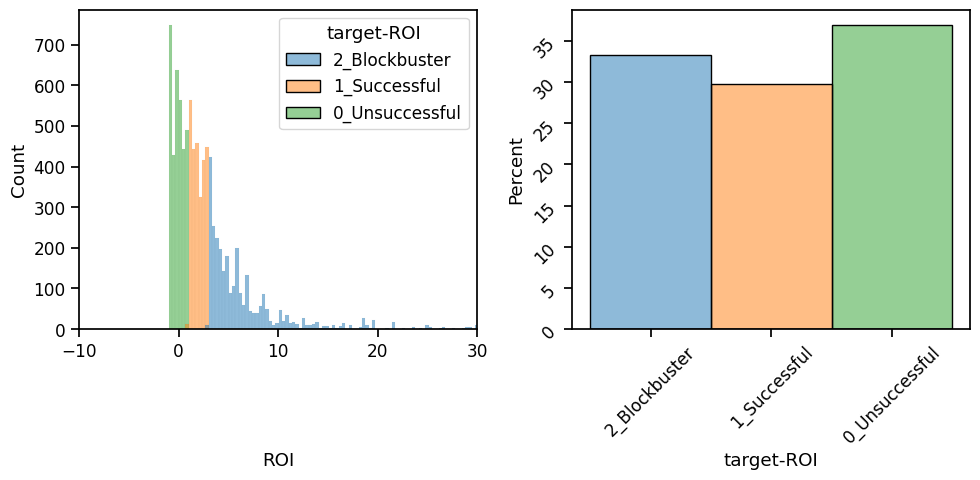

In [12]:
# ax = sns.histplot(data=df, x=target_col, hue)


fig, (ax1,ax2) =  plt.subplots(ncols=2, figsize=(10,5))
sns.histplot(data=df, x='ROI', hue='target-ROI', ax=ax1)#, kde=True)
sns.histplot(data=df, x='target-ROI', hue='target-ROI', ax=ax2, legend=False, stat='percent')
# Zoom in on hisgtogram
ax1.set_xlim(left=-10, right=30)
ax2.tick_params(labelrotation=45)
fig.align_xlabels()
fig.tight_layout()


#### Re-Definng target

In [13]:
# # Function to categorize movies
# def categorize_movie_success(roi):
#     if roi < 1:
#         return '1_Unsuccessful'
#     elif roi < 3:
#         return '2_Successful'
#     else:
#         return '3_Blockbuster'

# df['target-ROI'] = df['ROI'].map(categorize_movie_success)
# df['target-ROI'].value_counts(dropna=False, normalize=True)

In [14]:
df[target_col].value_counts(dropna=False, normalize=True)

0_Unsuccessful    0.369366
2_Blockbuster     0.333110
1_Successful      0.297523
Name: target-ROI, dtype: float64

In [15]:
sorted(df[target_col].unique())

['0_Unsuccessful', '1_Successful', '2_Blockbuster']

In [16]:
# # ## Combining Target Groups
# # target_map = {'0_Flop':"Low (ROI<1)", 
# #               '1_Moderate Success':"", '2_Success', '3_Blockbuster'

# # Function to categorize movies
# def categorize_movie_binary(roi):
#     if roi < 0:
#         return '0_Flop'
#     elif roi < 1:
#         return '1_Moderate Success'
#     elif roi < 3:
#         return '2_Success'
#     else:
#         return '3_Blockbuster'

# df['target-ROI'] = df['ROI'].map(categorize_movie)
# df['target-ROI'].value_counts(dropna=False, normalize=True)


In [17]:
# Creating df-ml by selecting final target (dropna or filter out group)
df_ml = df.dropna(subset=[target_col])
# df_ml = df.loc[ df[target_col]!="Mid"]
df_ml = df_ml.set_index('review_id')
print(df_ml[target_col].value_counts(dropna=False, normalize=True))
df_ml.head(2)

0_Unsuccessful    0.369366
2_Blockbuster     0.333110
1_Successful      0.297523
Name: target-ROI, dtype: float64


,imdb_id,movie_id,budget,revenue,original_title,original_language,overview,tagline,certification,rating,review_text,created_at,review_text_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,profit,target-profit,ROI,target-ROI,target-rating
review_id,,,,,,,,,,,,,,,,,,,,,,,,
64a3999fe9da6900c763aa8d,tt2096672,100042,40000000,169837010,Dumb and Dumber To,en,"20 years since their first adventure, Lloyd and Harry go on a road trip to find Harry's newly discovered daughter, who was given up for adoption.",The average person uses 10% of their brain capacity. Imagine what he could do with 1%.,PG-13,7.0,Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.,2023-07-04 04:01:35.517,Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.,"[better, then, the, original, i, think, was, pretty, funny, i, thought, the, comedy, was, better, then, the, original, too]","[better, original, think, pretty, funny, thought, comedy, better, original]","[well, original, think, pretty, funny, think, comedy, well, original]",better then the original i think was pretty funny i thought the comedy was better then the original too,better original think pretty funny thought comedy better original,well original think pretty funny think comedy well original,129837010,True,3.245925,2_Blockbuster,Mid
643d44864d67910469d853a2,tt0429573,10008,14000000,29612137,An American Haunting,en,Based on the true events of the only case in US History where a spirit caused the death of a man.,Possession Knows No Bounds,None,5.0,Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.,2023-04-17 13:07:18.832,Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.,"[kind, of, boring, it, 's, a, good, plot, and, storyline, nothing, really, to, keep, you, interested]","[kind, boring, good, plot, storyline, interested]","[kind, boring, good, plot, storyline, interested]",kind of boring it 's a good plot and storyline nothing really to keep you interested,kind boring good plot storyline interested,kind boring good plot storyline interested,15612137,True,1.115153,1_Successful,Mid


In [18]:
df_ml[target_col].value_counts(1)

0_Unsuccessful    0.369366
2_Blockbuster     0.333110
1_Successful      0.297523
Name: target-ROI, dtype: float64

In [19]:
X = df_ml[text_col]
y = df_ml[target_col]
X.head()

review_id
64a3999fe9da6900c763aa8d                                                                                                                                                   Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.
643d44864d67910469d853a2                                                                                                                                                                       Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.
5f22bd2b43999b00355b26a6    Heartwarming, if not as impactful as it intends to be.\r\n\r\n'Brother Bear' leaves heartfelt feelings and features a cute story. It does get a bit too melancholic in moments where it doesn't need to be or where it's not set up perfectly. It can ...
6592736214956560f7da631f    "Kenai" is a young Inuit warrior who disturbs the spirits when he kills a bear. His punishment is to be turned into one himself,

In [20]:
# Disable parser and ner
# nlp_light = spacy.load("en_core_web_sm", disable=['parser','ner'])

In [21]:
## Train test split
X_train, X_test, y_train_names, y_test_names = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)
X_train.head()

review_id
58d808c59251411f8905c59f    **But it was all about the sub-operation 'X-Ray'.**\r\n\r\nBringing the stars from other film industry is not we never heard of. It is mainly done for the international appeal. So now it was Liam Neeson's turn to foray into a Korean film. He did ...
612b00d5e04aca0043e2a4a1                                    This movie has a weak understanding of not only the truth in the relationship between the two characters based on actual people, but simplifies the subject of race relations. It was a terrible choice for best picture.
6116ecdecee481002e284eea    I was pleasantly surprised by this one, I had not watched any trailers in the run up to watching it but I was expecting it to be a bit lame but it turned out to be a good movie. I was surprised when pretty much the whole first team was killed off...
57d49dfd92514136fa001890    The woefully generic **When the Bough Breaks** has the gloss factor going for it to a certain extent. Truthfully, its presentabl

### Label Encoding

In [22]:
from sklearn.preprocessing import LabelEncoder

# Instansiate label encoder
encoder = LabelEncoder()

# Fit and transform the training target
y_train = pd.Series(encoder.fit_transform(y_train_names), 
                    index=y_train_names.index, 
                    name=y_train_names.name)

# Fit and tranform the test target
y_test = pd.Series(encoder.transform(y_test_names), index=y_test_names.index, 
                    name=y_test_names.name)

y_train[:10]

review_id
58d808c59251411f8905c59f    1
612b00d5e04aca0043e2a4a1    2
6116ecdecee481002e284eea    0
57d49dfd92514136fa001890    1
5f8ca97a89f7490037ff2a08    2
631fa2995684630083cd4c4e    2
5f3eaa00028f14003356044e    0
6078cbe21b1f3c0040d2b8c2    2
54559acec3a3683e23000c26    0
63bb9733a6e2d20092107cc2    2
Name: target-ROI, dtype: int64

In [23]:
y_train.value_counts(1)

0    0.364718
2    0.336011
1    0.299271
Name: target-ROI, dtype: float64

## Modeling

In [24]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))
vectorizer.fit(X_train)

CountVectorizer()

In [25]:
# Saves vocab - matches number of columns above
vocab_dict = vectorizer.vocabulary_
len(vocab_dict)

45292

In [26]:
# Words are now the feature_names
feature_names = vectorizer.get_feature_names_out()
len(feature_names)

45292

In [27]:
# FPATHS

### DummyClassifier

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.36      0.34      0.35      2452
           1       0.32      0.33      0.33      2012
           2       0.33      0.34      0.34      2259

    accuracy                           0.34      6723
   macro avg       0.34      0.34      0.34      6723
weighted avg       0.34      0.34      0.34      6723



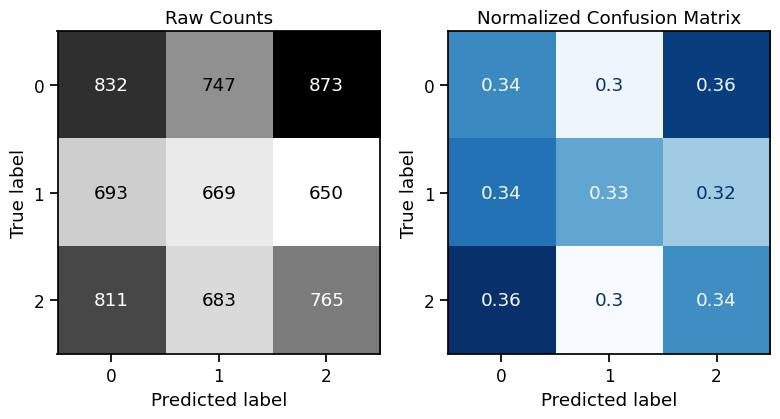


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.40      0.39      0.39       859
           1       0.32      0.33      0.32       655
           2       0.36      0.36      0.36       727

    accuracy                           0.36      2241
   macro avg       0.36      0.36      0.36      2241
weighted avg       0.36      0.36      0.36      2241



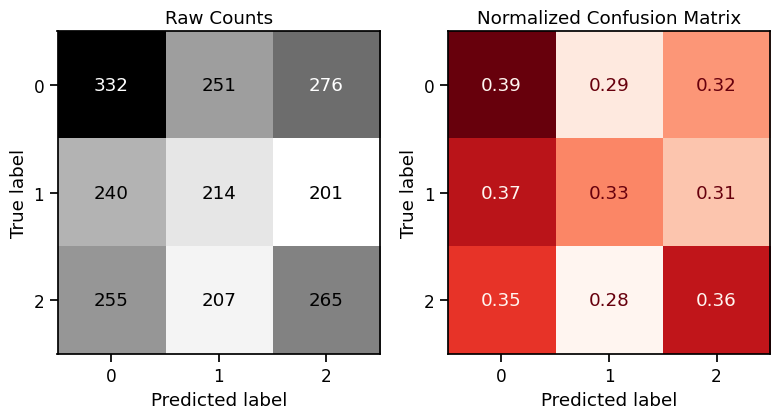

In [28]:
from sklearn.dummy import DummyClassifier
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_pipe = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',DummyClassifier(strategy='stratified'))
])

## Fit an evaluate a Logistic Regression
clf_pipe.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test,figsize=(8,12),values_format=".2g")
# joblib.dump(clf_pipe, FPATHS['models']['ml']['logreg'])

### Bayes

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2452
           1       0.99      0.98      0.99      2012
           2       0.98      0.99      0.99      2259

    accuracy                           0.99      6723
   macro avg       0.99      0.99      0.99      6723
weighted avg       0.99      0.99      0.99      6723



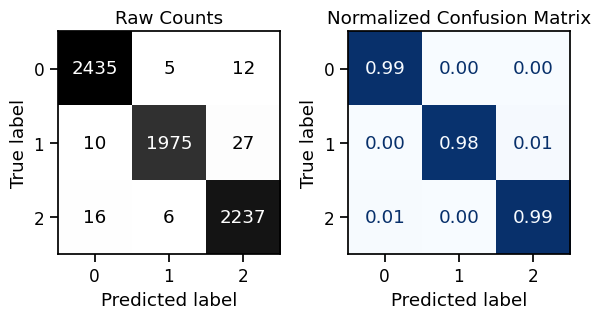


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.86      0.64       859
           1       0.60      0.20      0.31       655
           2       0.61      0.47      0.53       727

    accuracy                           0.54      2241
   macro avg       0.57      0.51      0.49      2241
weighted avg       0.57      0.54      0.51      2241



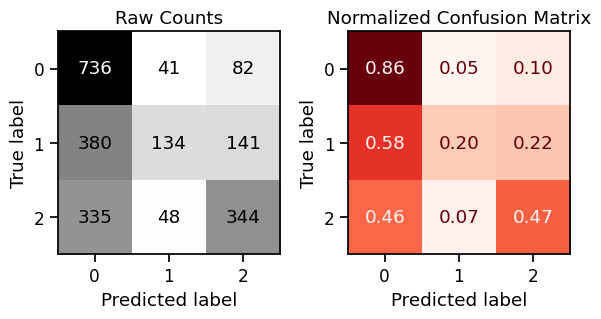

['Models/bayes-clf.joblib']

In [29]:
vectorizer = CountVectorizer(stop_words='english',
    ngram_range=(1,2)
                            )

clf_bayes = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',MultinomialNB())
])

## Fit an evaluate a Bayesian Model
clf_bayes.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_bayes, X_train,y_train, X_test, y_test)
joblib.dump(clf_bayes, FPATHS['models']['ml']['bayes'])

### LogisticRegression

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2452
           1       1.00      1.00      1.00      2012
           2       1.00      1.00      1.00      2259

    accuracy                           1.00      6723
   macro avg       1.00      1.00      1.00      6723
weighted avg       1.00      1.00      1.00      6723



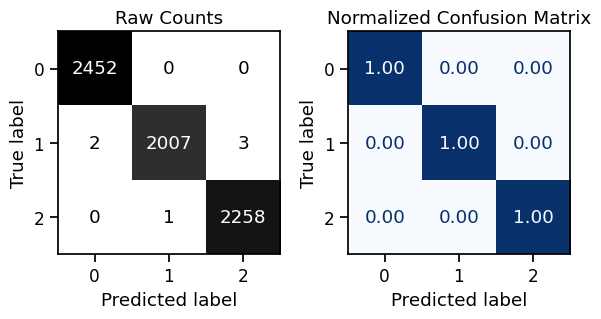


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.51      0.52       859
           1       0.41      0.44      0.43       655
           2       0.47      0.47      0.47       727

    accuracy                           0.47      2241
   macro avg       0.47      0.47      0.47      2241
weighted avg       0.48      0.47      0.48      2241



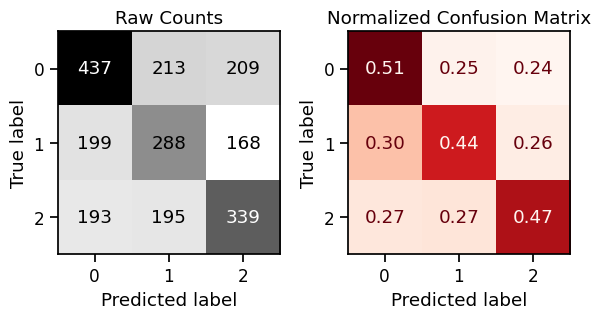

['Models/log-reg.joblib']

In [30]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_logreg = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LogisticRegression(max_iter=500,C=1e12))
])

## Fit an evaluate a Logistic Regression
clf_logreg.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg'])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2452
           1       1.00      1.00      1.00      2012
           2       1.00      1.00      1.00      2259

    accuracy                           1.00      6723
   macro avg       1.00      1.00      1.00      6723
weighted avg       1.00      1.00      1.00      6723



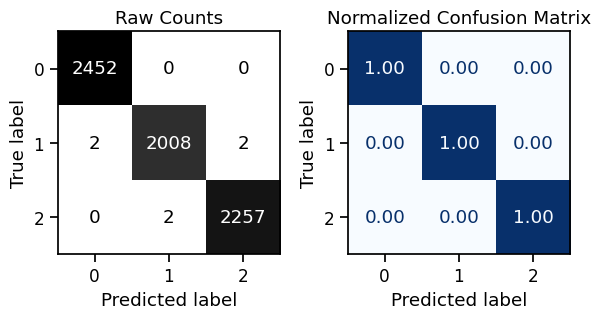


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.54      0.66      0.60       859
           1       0.46      0.44      0.45       655
           2       0.55      0.43      0.48       727

    accuracy                           0.52      2241
   macro avg       0.52      0.51      0.51      2241
weighted avg       0.52      0.52      0.52      2241



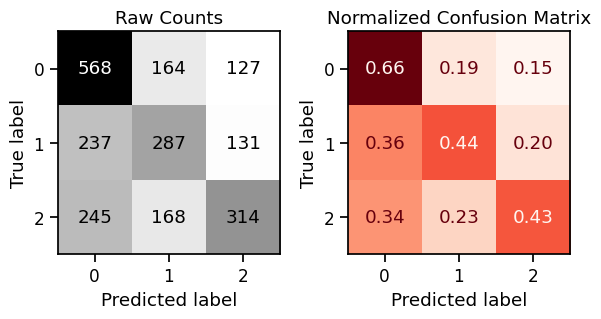

['Models/log-reg.joblib']

In [31]:
# Logreg-tfidf

vectorizer = TfidfVectorizer(stop_words=None,
    ngram_range=(1,2))

clf_logreg = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LogisticRegression(max_iter=500,C=1e12))
])

## Fit an evaluate a Logistic Regression
clf_logreg.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg'])

In [ ]:
# LogregCV-tfidf 

vectorizer = TfidfVectorizer(stop_words=None,
    ngram_range=(1,2))

clf_logreg = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LogisticRegressionCV(max_iter=200))
])

## Fit an evaluate a Logistic Regression
clf_logreg.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg'])

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

In [ ]:
# ## Fit an evaluate a Naive Bayes Classifier
# clf_bayes.fit(X_train, y_train)
# ds.evaluate.evaluate_classification(clf_bayes, X_train,y_train, X_test, y_test)
# joblib.dump(clf_bayes, FPATHS['models']['ml']['bayes'])

### RandomForest

In [ ]:
FPATHS['models']['ml']['random_forest']

In [ ]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_rf = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',RandomForestClassifier(class_weight='balanced'))
])

## Fit an evaluate a Logistic Regression
clf_rf.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_rf, X_train,y_train, X_test, y_test)
joblib.dump(clf_rf, FPATHS['models']['ml']['random_forest'])

In [ ]:
vectorizer = TfidfVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_rf = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',RandomForestClassifier(class_weight='balanced'))
])

## Fit an evaluate a Logistic Regression
clf_rf.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_rf, X_train,y_train, X_test, y_test)
# joblib.dump(clf_rf, FPATHS['models']['ml']['random_forest'])

### SVC

In [ ]:
from sklearn.svm import SVC, LinearSVC

## GridSearching ML Models/Prep

In [ ]:
# Define params to try for both vectorizers
# param_grid_clf = {'clf__C': [1e12,1e10]}

param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    # "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]
params_combined

In [ ]:
logreg_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer()),
    ('clf',LogisticRegression(max_iter=500))
])

In [ ]:
%%time
# Create grid search
grid_search = GridSearchCV(logreg_pipe, params_combined, scoring='recall_macro',cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)


In [ ]:
# grid_search.best_params_


In [ ]:
# # Now define the best version of the model
# best_model = grid_search.best_estimator_

# # Predict and Evaluate with the custom function
# ds.evaluate_classification(best_model, X_train, y_train, X_test, y_test)


## GS from LP

In [ ]:
# param_grid_shared = {
#     "vectorizer__max_df": [0.7, 0.8, 0.9],
#     'vectorizer__min_df': [ 2, 3, 4 ], 
#     # "vectorizer__max_features": [None, 1000, 2000],
#     "vectorizer__stop_words": [None,'english']
# }

# # Setting params for the count vectorizer
# param_grid_count = {
#     'vectorizer':[CountVectorizer()],
#     **param_grid_shared
# }


# # Setting params for tfidf vectorizer 
# param_grid_tfidf = {
#     'vectorizer': [TfidfVectorizer()],
#     "vectorizer__norm": ["l1", "l2"],
#     "vectorizer__use_idf": [True, False],
#     **param_grid_shared
# }


# # Define parameters to tune multiple models

# param_grid_RF = {
#     'clf' : [RandomForestClassifier(random_state = 42)],
#     'clf__max_depth' : [5, None],
#     'clf__min_samples_leaf' : [1, 2],
# }

# param_grid_MNB = {
#     'clf' : [MultinomialNB()],
#     'clf__alpha' : [.5, 1],
# }

# param_grid_logreg = {
#     'clf': [LogisticRegression(random_state = 42)],
#     'clf__C' : [.1, 1, 10, 100],
# }

# # combine into list of params
# model_params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]




In [ ]:
# Set up Pipeline to allow GridSearching different vectorizers
vect_pipe = Pipeline([('vectorizer', CountVectorizer()), # This is just a placeholder
                     ('clf',MultinomialNB())])



In [ ]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]



In [ ]:
# Define parameters to tune multiple models

# param_grid_RF = {
#     'clf' : [RandomForestClassifier(random_state = 42)],
#     'clf__max_depth' : [20, None],
#     'clf__min_samples_leaf' : [1, 2],
# }

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

param_grid_logreg = {
    'clf': [LogisticRegression(max_iter=1000,random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
}

# combine into list of params
model_params_combined = [
    # param_grid_RF,
    param_grid_MNB, 
    param_grid_logreg]

In [ ]:
import itertools

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
paired_param_grids[0]

In [ ]:
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]

In [ ]:
# %%time
## TEMP: COMPARE TIMING IF n_jobs is NOT -1
# # Create grid search
# grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1)#, n_jobs=-1)
    
    
# # Fit the model
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [ ]:
%%time
SKIP = True

if not SKIP:
    # Create grid search
    grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'recall_macro', verbose=2, n_jobs=-1)
        
        
    # Fit the model
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

In [ ]:
if not SKIP:
    
    # Now define the best version of the model
    best_model = grid_search.best_estimator_
    
    # Predict and Evaluate with the custom function
    ds.evaluate.evaluate_classification(best_model, X_train, y_train, X_test, y_test)

### Saving ML Model & Data

In [ ]:

# Save training data
fpath_train_joblib = FPATHS['data']['ml']['train']
joblib.dump([X_train, y_train],fpath_train_joblib)

# Save test data
fpath_test_joblib = FPATHS['data']['ml']['test']
joblib.dump([X_test, y_test],fpath_test_joblib)

# if not SKIP:
#     # Saving the best model 
#     fpath_best_ml_model  = "Models/best-ml-model.joblib"
#     joblib.dump(best_model, fpath_best_ml_model)

## 👉11/30/23 Brenda 1:1 - Admin Test/Demo

### Ngrams

In [ ]:
#our pre-exting ngram df function https://login.codingdojo.com/m/692/16501/124388

import pandas as pd
def get_ngram_measures_finder(tokens, ngrams=2, get_scores_df=False, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams

### Text Explainer

In [ ]:
X_to_pred = 'It was the best move i had ever seen until the last 30 mins, which ruined the whole thing.'

In [ ]:
y

In [ ]:
clf_bayes.predict([X_to_pred])

In [ ]:
y.unique()

In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=y.unique())
explanation = explainer.explain_instance(X_to_pred, clf_bayes.predict_proba)
explanation.show_in_notebook()

# Neural Networks

In [ ]:
# raise

## ✅🚨 TO DO 11/30

- Write up tensorflow deployment lesson as I finalize model and dataset saving/loading 

In [ ]:
def save_model(
    model=None,
    model_folder=None,
    overwrite=False,
    save_model_kws={},
    load_and_evaluate=True,
    train_ds=None,
    test_ds=None,
):
    ## allowing for JUST loading if no model and load_and_eval==True
    if (model == None) & (load_and_evaluate == None):
        raise Exception(
            "[!] Must either provide a model to save or sert load_and_evaluate to True to load only."
        )

    if model_folder == None:
        model_folder = "Models/model01/"

    # Create folder
    os.makedirs(model_folder, exist_ok=True)

    # Save Model. with keras.models.save_model
    try:
        tf.keras.models.save_model(model, model_folder, **save_model_kws)

    except Exception as e:
        print("[!] Save failed:")
        display(e)

    if load_and_evaluate == True:
        loaded = tf.keras.models.load_model(model_folder)
        display(
            ds.evaluate_classification_network(loaded, X_train=train_ds, X_test=test_ds)
        )  # , history=history);
        return loaded

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Define X and y
X = df_ml[text_col]
y_string= df_ml[target_col]

# Instantiate the LabelEncoder
encoder = LabelEncoder()

# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y_string))
y.value_counts()

In [ ]:
# Convert to Dataset Object
full_ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
full_ds = full_ds.shuffle(buffer_size=len(full_ds), reshuffle_each_iteration=False,seed=321)

In [ ]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(full_ds) * split_train)
n_val_samples = int(len(full_ds) * split_val)
n_test_samples = len(full_ds) -(n_train_samples + n_val_samples)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")



In [ ]:
# Use take and skip to define each set
train_ds = full_ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
train_ds = train_ds.shuffle(len(train_ds), seed=321)
# Skip over the training batches and take the validation batches
val_ds = full_ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = full_ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')



In [ ]:
# # taking a sample 
# example_X, example_y= train_ds.take(1).get_single_element()
# print(example_X)
# print(example_y)

In [ ]:
## Saving Train and test dataset
fname_train_ds = FPATHS['data']['nn']['train']
train_ds.save(path=fname_train_ds,)

fname_test_ds = FPATHS['data']['nn']['test']
test_ds.save(path=fname_test_ds,)

In [ ]:
df_ml = df_ml.copy()
df_ml['sequence_length'] = df_ml['review_text'].map( lambda x: len(x.split(" ")))
ax = sns.histplot(df_ml['sequence_length'])

In [ ]:
ax = sns.boxplot(data=df_ml, x='sequence_length')

In [ ]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
# ds_texts.take(1).get_single_element()

In [ ]:
SEQUENCE_LENGTH = 300
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)
sequence_vectorizer.adapt(ds_texts)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE


In [ ]:
# raise Exception("Update code below to use only what is shown on the LP")

#### LSTM

In [ ]:
# Define a function for building an LSTM model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.models import Sequential

# @tf.function
def build_lstm_model(text_vectorization_layer):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()

    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential(
        [
            text_vectorization_layer,
            layers.Embedding(
                input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH
            ),
        ]
    )

    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(64,recurrent_dropout=.1, return_sequences=True))
    lstm_model.add(layers.Dropout(0.5))
    lstm_model.add(layers.LSTM(32))#, return_sequences=True)))
    # lstm_model.add(layers.GlobalMaxPooling1D())

    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation="softmax"))

    # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  # 0.9)
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    lstm_model.compile(
        optimizer=optimizer,  #'adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    lstm_model.summary()
    return lstm_model

In [ ]:
# # Code below is from CNN Week
# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, verbose=True)
#     return [early_stop]


### Call backs
# @tf.function
def get_callbacks(monitor='val_accuracy',patience=3, restore_best_weights=False,
                  start_from_epoch=0,baseline_value=None,
                  verbose_early_stopping=1,  
                  tensborboard=False, logdir="/tmp/tb_logs",
                 tb_embed_freq=0, tb_write_images = False, tb_hist_freq = 0):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, #mode=mode, 
                                                      restore_best_weights=restore_best_weights,
                                                      baseline=baseline_value,
                                                      start_from_epoch=start_from_epoch,
                                                      verbose=verbose_early_stopping)

    if tensborboard:
        tboard = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=tb_hist_freq,write_images=tb_write_images,
                                                embeddings_freq=tb_embed_freq,)
        return [ early_stopping, tboard]
    else:
        return [early_stopping]

In [ ]:
EMBED_DIM = 50
classes = y_train.unique()
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

ds.evaluate.plot_history(history)

In [ ]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

In [ ]:
# raise Exception("Add model fpaths to filepaths.json first and then use those below:")

#### Saving Model 1

In [ ]:
# Saving model in tf format 
fname_model_lstm = FPATHS['models']['nn']['LSTM']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
lstm_model.save(fname_model_lstm, save_format='tf')

In [ ]:
## Loading the Model
loaded_network = tf.keras.models.load_model(fname_model_lstm)
loaded_network.summary()

In [ ]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    loaded_network, X_train=train_ds, 
    X_test=test_ds, history=history
);

## Testing Saving/Loading Dataset Objects

### RNN Model 2

In [ ]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=MAX_TOKENS,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))
    
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

In [ ]:
EMBED_DIM = 50
classes = y_train.unique()
MAX_TOKENS = sequence_vectorizer.vocabulary_size()
# Build the lstm model and specify the vectorizer
bidirection_model = build_gru_model_bi_pool(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = bidirection_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
ds.evaluate.plot_history(history)

In [ ]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    bidirection_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

In [ ]:
# Saving model in tf format 
fname_model_gru = FPATHS['models']['nn']['GRU']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
bidirection_model.save(fname_model_gru, save_format='tf')

### Saving Tensorflow Datasets and Best Model